<center>
    <p style="text-align:center">
        <img alt="phoenix logo" src="https://storage.googleapis.com/arize-assets/phoenix/assets/phoenix-logo-light.svg" width="200"/>
        <br>
        <a href="https://docs.arize.com/phoenix/">Docs</a>
        |
        <a href="https://github.com/Arize-ai/phoenix">GitHub</a>
        |
        <a href="https://join.slack.com/t/arize-ai/shared_invite/zt-1px8dcmlf-fmThhDFD_V_48oU7ALan4Q">Community</a>
    </p>
</center>
<h1 align="center">Code Functionality  Evals</h1>


This tests whether code is written correctly, without bugs, accomplishes the functionality you want, does not have syntax errors.

The purpose of this notebook is:

- to evaluate the performance of code fuctionality Eval
- to provide an experimental framework for users to iterate and improve on the default classification template.

## Install Dependencies and Import Libraries

In [4]:
#!pip install -qq "arize-phoenix[experimental]" "openai>=1" ipython matplotlib pycm scikit-learn tiktoken nest_asyncio

ℹ️ To enable async request submission in notebook environments like Jupyter or Google Colab, optionally use `nest_asyncio`. `nest_asyncio` globally patches `asyncio` to enable event loops to be re-entrant. This is not required for non-notebook environments.

Without `nest_asyncio`, eval submission can be much slower, depending on your organization's rate limits. Speed increases of about 5x are typical.

In [1]:
import nest_asyncio

nest_asyncio.apply()

In [2]:
import os
from getpass import getpass

import matplotlib.pyplot as plt
import pandas as pd
from phoenix.experimental.evals import (
    CODE_FUNCTIONALITY_PROMPT_TEMPLATE,
    CODE_FUNCTIONALITY_PROMPT_RAILS_MAP,
    OpenAIModel,
    download_benchmark_dataset,
    llm_classify,
)
from pycm import ConfusionMatrix
from sklearn.metrics import classification_report

pd.set_option("display.max_colwidth", None)

/Users/jasonlopatecki/vs_projects/evals_tests/link_evals/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Download Benchmark Dataset

TODO

In [3]:
df = pd.read_csv("https://storage.googleapis.com/arize-assets/phoenix/evals/code-functionality/validated_python_code_samples_2.csv")

df.head()

,coding_instruction,code,is_well_coded
0,Create a neural network in Python from scratch that takes a 2D array of numbers as its input and predicts the sum of the numbers in each row.,"import numpy as np\n\nclass NeuralNetwork:\n def __init__(self, input_size):\n self.weights = np.random.rand(input_size, 1)\n self.bias = np.random.rand(1, 1)\n\n def predict(self, X):\n return np.dot(X, self.weights) + self.bias\n\n# Example Usage:\ninput_data = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])\nnn = NeuralNetwork(input_size=input_data.shape[1])\npredictions = nn.predict(input_data)\nprint(predictions)",True
1,Generate a Python program to find the mode of the given list.,"from statistics import mode\n\ndef find_mode(input_list):\n try:\n result = mode(input_list)\n return result\n except StatisticsError:\n return ""No unique mode found""\n\n# Example Usage:\ndata_list = [1, 2, 2, 3, 4, 4, 5]\nmode_result = find_mode(data_list)\nprint(mode_result)",True
2,Develop a text summarizer in Python that takes a text input and returns a summary of the text in two sentences.,"from nltk import sent_tokenize\nfrom nltk.corpus import stopwords\nfrom nltk.stem import PorterStemmer\nfrom sklearn.feature_extraction.text import TfidfVectorizer\nfrom sklearn.metrics.pairwise import cosine_similarity\n\ndef text_summarizer(text):\n sentences = sent_tokenize(text)\n stop_words = set(stopwords.words('english'))\n vectorizer = TfidfVectorizer()\n ps = PorterStemmer()\n\n def preprocess_sentence(sentence):\n words = [ps.stem(word) for word in sentence.split() if word.lower() not in stop_words]\n return ' '.join(words)\n\n preprocessed_sentences = [preprocess_sentence(sentence) for sentence in sentences]\n\n try:\n tfidf_matrix = vectorizer.fit_transform(preprocessed_sentences)\n sentence_similarity = cosine_similarity(tfidf_matrix, tfidf_matrix)\n except ValueError:\n return ""Input text is too short for summarization.""\n\n sentence_scores = [(index, sum(sentence_similarity[index])) for index in range(len(sentences))]\n sentence_scores = sorted(sentence_scores, key=lambda x: x[1], reverse=True)\n\n summary_sentences = [sentences[score[0]] for score in sentence_scores[:2]]\n summary = ' '.join(summary_sentences)\n\n return summary\n\n# Example Usage:\ninput_text = ""Your input text goes here. It should be a longer piece of text for meaningful summarization.""\nsummary_result = text_summarizer(input_text)\nprint(summary_result)",True
3,Create a program in Python to generate random passwords of 8 characters.,import random\nimport string\n\ndef generate_random_password():\n password_length = 8\n characters = string.ascii_letters + string.digits + string.punctuation\n password = ''.join(random.choice(characters) for i in range(password_length))\n return password\n\n# Example Usage:\nrandom_password = generate_random_password()\nprint(random_password),True
4,Design a python program to replace every occurrence of a word in a string with another word.,"def replace_word(string, word, replacement_word):\n return string.replace(word)\n\nprint(replace_word(""Hello hello world!"", ""hello"", ""welcome""))",False




```
# This is formatted as code
```

## Display Code Functionality Classification Template

View the default template used to code functionality. You can tweak this template and evaluate its performance relative to the default.

In [7]:
print(CODE_FUNCTIONALITY_PROMPT_RAILS_MAP)

OrderedDict([(True, 'bug_free'), (False, 'is_bug')])


In [5]:
print(CODE_FUNCTIONALITY_PROMPT_TEMPLATE)


Code Evaluation Prompt:
-----------------------
Evaluate the provided code to determine its correctness in solving the given instruction.

Data:
-----
[Instruction]: {coding_instruction}
  Clearly define the task or problem that the code aims to address.

[Reference Code]: {code}
  Examine the submitted code for evaluation in the context of the provided instruction.

Evaluation:
-----------
Provide a concise response with a single word: either "bug_free" or "is_bug".
- "bug_free" signifies that the code correctly and efficiently solves the instruction with no bugs.
- "is_bug" indicates that the code either fails to meet the instruction requirements or contains bugs.

Example:
-----------

[Instruction]: Implement the Fibonacci sequence in Python.

[Reference Code]: 'def fibonacci(n):
    if n <= 1:
        return n
    else:
        return fibonacci(n - 1) + fibonacci(n - 2)

for i in range(10):
    print(fibonacci(i))'

[Output]: bug_free

Note: Assumptions can be made that any code 

The template variables are:

- **input:** TODO
- **reference:** TODO
- **output:** TODO

## Configure the LLM

Configure your OpenAI API key.

In [ ]:
if not (openai_api_key := os.getenv("OPENAI_API_KEY")):
    openai_api_key = getpass("🔑 Enter your OpenAI API key: ")
os.environ["OPENAI_API_KEY"] = openai_api_key

## Benchmark Dataset Sample
Sample size determines run time
Recommend iterating small: 100 samples
Then increasing to large test set

## LLM Evals: Code Functionality Classifications GPT-4
Run Code Functionality against a subset of the data.
Instantiate the LLM and set parameters.

In [ ]:
model = OpenAIModel(
    model_name="gpt-4",
    temperature=0.0,
)

In [ ]:
model("Hello world, this is a test if you are working?")

"Hello! I'm working perfectly. How can I assist you today?"

## Run Code Func Classifications

Run code functionality classifications against a subset of the data.

In [ ]:
# The rails is used to hold the output to specific values based on the template
# It will remove text such as ",,," or "..."
# Will ensure the binary value expected from the template is returned
rails = list(CODE_FUNCTIONALITY_RAIL_MAP.values())
relevance_classifications = llm_classify(
    dataframe=df,
    template=CODE_FUNCTIONALITY_PROMPT_TEMPLATE,
    model=model,
    rails=rails,
    concurrency=20,
)["label"].tolist()

llm_classify |          | 0/50 (0.0%) | ⏳ 00:00<? | ?it/s

## Evaluate Classifications

Evaluate the predictions against human-labeled ground-truth code functionality labels.

              precision    recall  f1-score   support

    bug_free       0.96      0.77      0.86        31
      is_bug       0.72      0.95      0.82        19

    accuracy                           0.84        50
   macro avg       0.84      0.86      0.84        50
weighted avg       0.87      0.84      0.84        50



<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

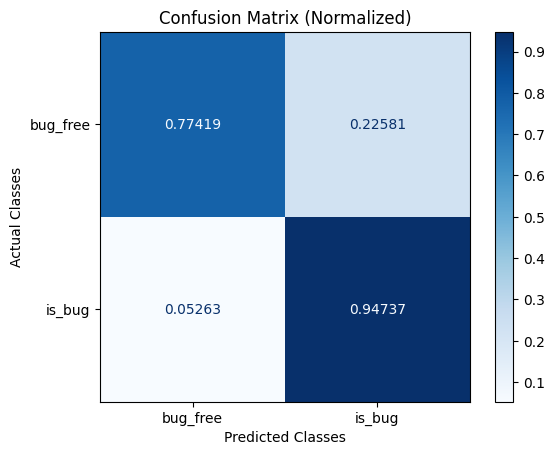

In [ ]:
true_labels = df["is_well_coded"].map(CODE_FUNCTIONALITY_RAIL_MAP).tolist()

print(classification_report(true_labels, relevance_classifications, labels=rails))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels, predict_vector=relevance_classifications, classes=rails
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)

## Classifications with explanations

When evaluating a dataset for code functionality, it can be useful to know why the LLM classified a document as relevant or irrelevant. The following code block runs `llm_classify` with explanations turned on so that we can inspect why the LLM made the classification it did. There is speed tradeoff since more tokens is being generated but it can be highly informative when troubleshooting.

In [ ]:
small_df_sample = df.copy().sample(n=5).reset_index(drop=True)
relevance_classifications_df = llm_classify(
    dataframe=small_df_sample,
    template=CODE_FUNCTIONALITY_PROMPT_TEMPLATE,
    model=model,
    rails=rails,
    provide_explanation=True,
    verbose=True,
    concurrency=20,
)

Using prompt:


Code Evaluation Prompt:
-----------------------
Evaluate the provided code to determine its correctness in solving the given instruction.

Data:
-----
[Instruction]: {coding_instruction}
  Clearly define the task or problem that the code aims to address.

[Reference Code]: {code}
  Examine the submitted code for evaluation in the context of the provided instruction.

Evaluation:
-----------
Provide a concise response with a single word: either "bug_free" or "is_bug".
- "bug_free" signifies that the code correctly and efficiently solves the instruction with no bugs.
- "is_bug" indicates that the code either fails to meet the instruction requirements or contains bugs.

Example:
-----------

[Instruction]: Implement the Fibonacci sequence in Python.

[Reference Code]: 'def fibonacci(n):
    if n <= 1:
        return n
    else:
        return fibonacci(n - 1) + fibonacci(n - 2)

for i in range(10):
    print(fibonacci(i))'

[Output]: bug_free

Note: Assumptions can be made

llm_classify |          | 0/5 (0.0%) | ⏳ 00:00<? | ?it/s

- Snapped 'bug_free' to rail: bug_free
- Snapped 'is_bug' to rail: is_bug
- Snapped 'is_bug' to rail: is_bug
- Snapped 'is_bug' to rail: is_bug
- Snapped 'is_bug' to rail: is_bug


In [ ]:
# Let's view the data
merged_df = pd.merge(
    small_df_sample, relevance_classifications_df, left_index=True, right_index=True
)
merged_df[["coding_instruction", "code", "label", "explanation"]].head()

,coding_instruction,code,label,explanation
0,Take the list of people below and create a Python dictionary with the names as keys and the ages as values.,"people_dict = {'John': '20', 'Jane': 40, 'Alex': 18, 'Peter': 45}",is_bug,"The code does not meet the instruction requirements. The instruction asks to create a Python dictionary from a list of people, but the code directly creates a dictionary without using a list. Moreover, the age of 'John' is given as a string instead of an integer."
1,Generate a Python function that takes a number less than 1000 and returns it written in words.,"def number_to_words(num):\n if num < 0 or num >= 1000:\n return ""Number out of range""\n \n ones = ["""", ""One"", ""Two"", ""Three"", ""Four"", ""Five"", ""Six"", ""Seven"", ""Eight"", ""Nine""]\n teens = ["""", ""Eleven"", ""Twelve"", ""Thirteen"", ""Fourteen"", ""Fifteen"", ""Sixteen"", ""Seventeen"", ""Eighteen"", ""Nineteen""]\n tens = ["""", ""Ten"", ""Twenty"", ""Thirty"", ""Forty"", ""Fifty"", ""Sixty"", ""Seventy"", ""Eighty"", ""Ninety""]\n\n def convert_below_100(n):\n if n == 0:\n return """"\n elif n < 10:\n return ones[n]\n elif n < 20:\n return teens[n - 10]\n else:\n return tens[n // 10] + "" "" + ones[n % 10]\n\n if num == 0:\n return ""Zero""\n elif num < 10:\n return ones[num]\n elif num < 100:\n return convert_below_100(num)\n else:\n hundred_part = ones[num // 100] + "" Hundred""\n rest_part = convert_below_100(num % 100)\n return (hundred_part + "" "" + rest_part).strip()\n\n# Example Usage:\nnumber = 789\nresult = number_to_words(number)\nprint(result)",is_bug,"The code correctly converts a number less than 1000 into words. It handles numbers from 0 to 999, including the edge cases of 0 and numbers in the tens that are less than 20. However, there is a bug in the code. The 'teens' list is missing the word for 'Ten'. This will cause an off-by-one error when the function tries to convert a number in the teens (10-19)."
2,Create an algorithm in Python to determine whether a given string is a palindrome.,# define a function to check if a string is a palindrome\ndef is_palindrome(string):\n # reverse the string \n reversed_string = string[::1]\n # check if reversed string is equal to original \n if string == reversed_string:\n return True\n else:\n return False\n \n# check for given string\nstring = 'malayalam'\nif is_palindrome(string):\n print(string + ' is a palindrome')\nelse:\n print(string + ' is not a palindrome'),is_bug,"The code is supposed to reverse the string to check if it's a palindrome. However, the slicing operation used to reverse the string is incorrect. It should be string[::-1] instead of string[::1]. The current code will not reverse the string, hence it will not correctly identify palindromes."
3,Write an algorithm for merging two sorted lists of integers into one sorted list in Python.,"def merge(list1, list2): \n # create an empty list to store the result \n mergedList = [] \n # set two index pointers \n i = 0 \n j = 0\n while (i < len(list1) and j < len(list2)): \n if (list1[i] < list2[j]): \n mergedList.append(list1[i]) \n i += 1\n else: \n mergedList.append(list2[j]) \n j += 1\n\n # check for remaining elements \n while (i < len(list1)): \n mergedList.append(list1[i]) \n i += 1\n\n while (j < len(list2)): \n mergedList.append(list2[j]) \n j += 1\n \n return mergedList \n \n# Driver code \nlist1 = [1, 3, 5, 8]\nlist2 = [2, 4, 6, 7]\n\n# function call \nmergedList = merge(list1, list2) \n\n# print result \nprint(mergedList)",bug_free,"The provided code correctly merges two sorted lists into one sorted list. It iterates over both lists simultaneously, comparing elements and adding the smaller one to the merged list. If one list is exhausted before the other, the remaining elements of the non-exhausted list are appended to the merged list. The final result is a correctly merged and sorted list."
4,Create a Python program for analyzing Twitter data. The program should accept a password (or token) as input 

## LLM Evals: code functionality Classifications GPT-3.5 Turbo
Run Code functionality against a subset of the data using GPT-3.5. GPT-3.5 can significantly speed up the classification process. However there are tradeoffs as  we will see below.

In [ ]:
model = OpenAIModel(model_name="gpt-3.5-turbo", temperature=0.0, request_timeout=20)

In [ ]:
rails = list(CODE_FUNCTIONALITY_RAIL_MAP.values())
relevance_classifications = llm_classify(
    dataframe=df,
    template=CODE_FUNCTIONALITY_PROMPT_TEMPLATE,
    model=model,
    rails=rails,
    concurrency=20,
)["label"].tolist()

llm_classify |          | 0/50 (0.0%) | ⏳ 00:00<? | ?it/s

              precision    recall  f1-score   support

    bug_free       0.80      0.90      0.85        31
      is_bug       0.80      0.63      0.71        19

    accuracy                           0.80        50
   macro avg       0.80      0.77      0.78        50
weighted avg       0.80      0.80      0.79        50



<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

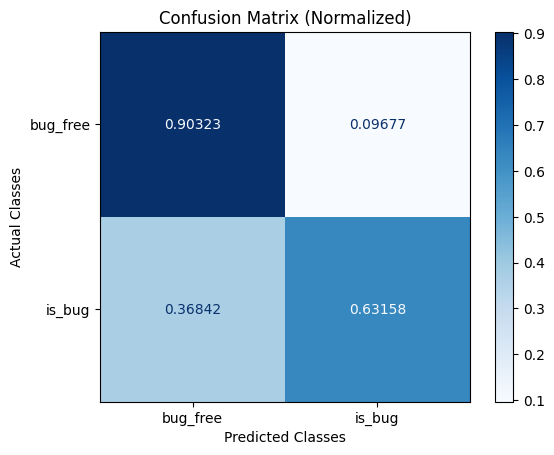

In [ ]:
true_labels = df["is_well_coded"].map(CODE_FUNCTIONALITY_RAIL_MAP).tolist()

print(classification_report(true_labels, relevance_classifications, labels=rails))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels, predict_vector=relevance_classifications, classes=rails
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)

## Preview: Running with GPT-4 Turbo

In [ ]:
model = OpenAIModel(model_name="gpt-4-1106-preview")
classifications = llm_classify(
    dataframe=df,
    template=CODE_FUNCTIONALITY_PROMPT_TEMPLATE,
    model=model,
    rails=list(CODE_FUNCTIONALITY_RAIL_MAP.values()),
    concurrency=20,
)["label"].tolist()

llm_classify |          | 0/50 (0.0%) | ⏳ 00:00<? | ?it/s

              precision    recall  f1-score   support

    bug_free       1.00      0.77      0.87        31
      is_bug       0.73      1.00      0.84        19

    accuracy                           0.86        50
   macro avg       0.87      0.89      0.86        50
weighted avg       0.90      0.86      0.86        50



<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

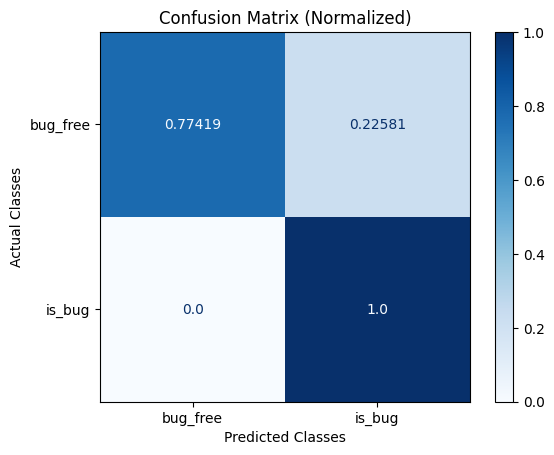

In [ ]:
true_labels = df["is_well_coded"].map(CODE_FUNCTIONALITY_RAIL_MAP).tolist()

print(classification_report(true_labels, classifications, labels=rails))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels, predict_vector=classifications, classes=rails
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)